In [1]:

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS=24

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Strawberry Leaf Dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1907 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Cercospora Leaf Spot',
 'Common Leaf Spot',
 'Healthy',
 'Leaf Blight',
 'Leaf Scortch']

In [6]:
len(dataset)

30

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

24

In [10]:
len(val_ds)

3

In [11]:
len(test_ds)

3

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
def create_model():
    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

model = create_model()
    
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [17]:

import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)


In [18]:
history = model.fit(train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[cp_callback]
)

Epoch 1/24
24/24 [==============================] - ETA: 0s - loss: 1.7271 - accuracy: 0.2653
Epoch 1: saving model to training_1\cp.ckpt
24/24 [==============================] - 16s 251ms/step - loss: 1.7271 - accuracy: 0.2653 - val_loss: 1.6797 - val_accuracy: 0.3542
Epoch 2/24
24/24 [==============================] - ETA: 0s - loss: 1.2964 - accuracy: 0.4399
Epoch 2: saving model to training_1\cp.ckpt
24/24 [==============================] - 3s 127ms/step - loss: 1.2964 - accuracy: 0.4399 - val_loss: 1.2250 - val_accuracy: 0.5469
Epoch 3/24
24/24 [==============================] - ETA: 0s - loss: 0.9235 - accuracy: 0.5995
Epoch 3: saving model to training_1\cp.ckpt
24/24 [==============================] - 3s 128ms/step - loss: 0.9235 - accuracy: 0.5995 - val_loss: 0.9484 - val_accuracy: 0.6719
Epoch 4/24
24/24 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.6671
Epoch 4: saving model to training_1\cp.ckpt
24/24 [==============================] - 3s 127ms/step

In [19]:

import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [20]:
import pickle
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

In [21]:
import os
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [22]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1\\cp.ckpt'

In [23]:
model = create_model()
model.load_weights(latest)

In [24]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 63ms/step - loss: 0.1075 - accuracy: 0.9832


In [25]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

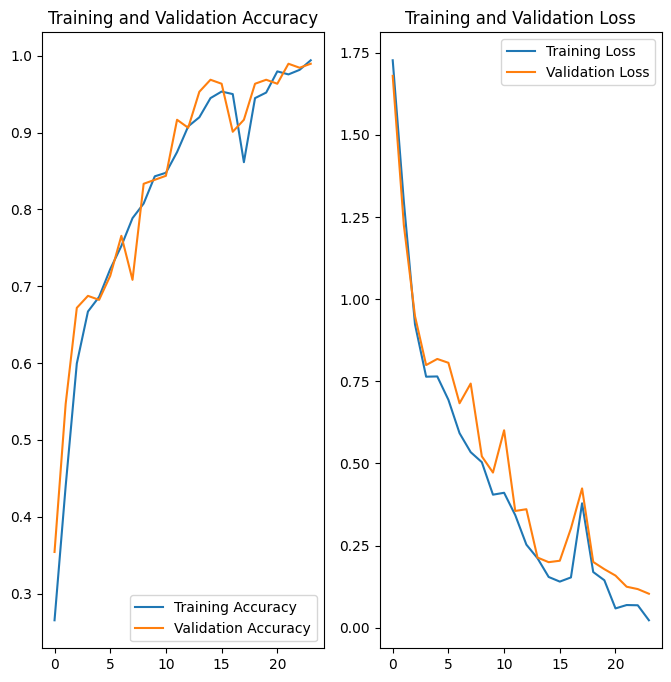

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


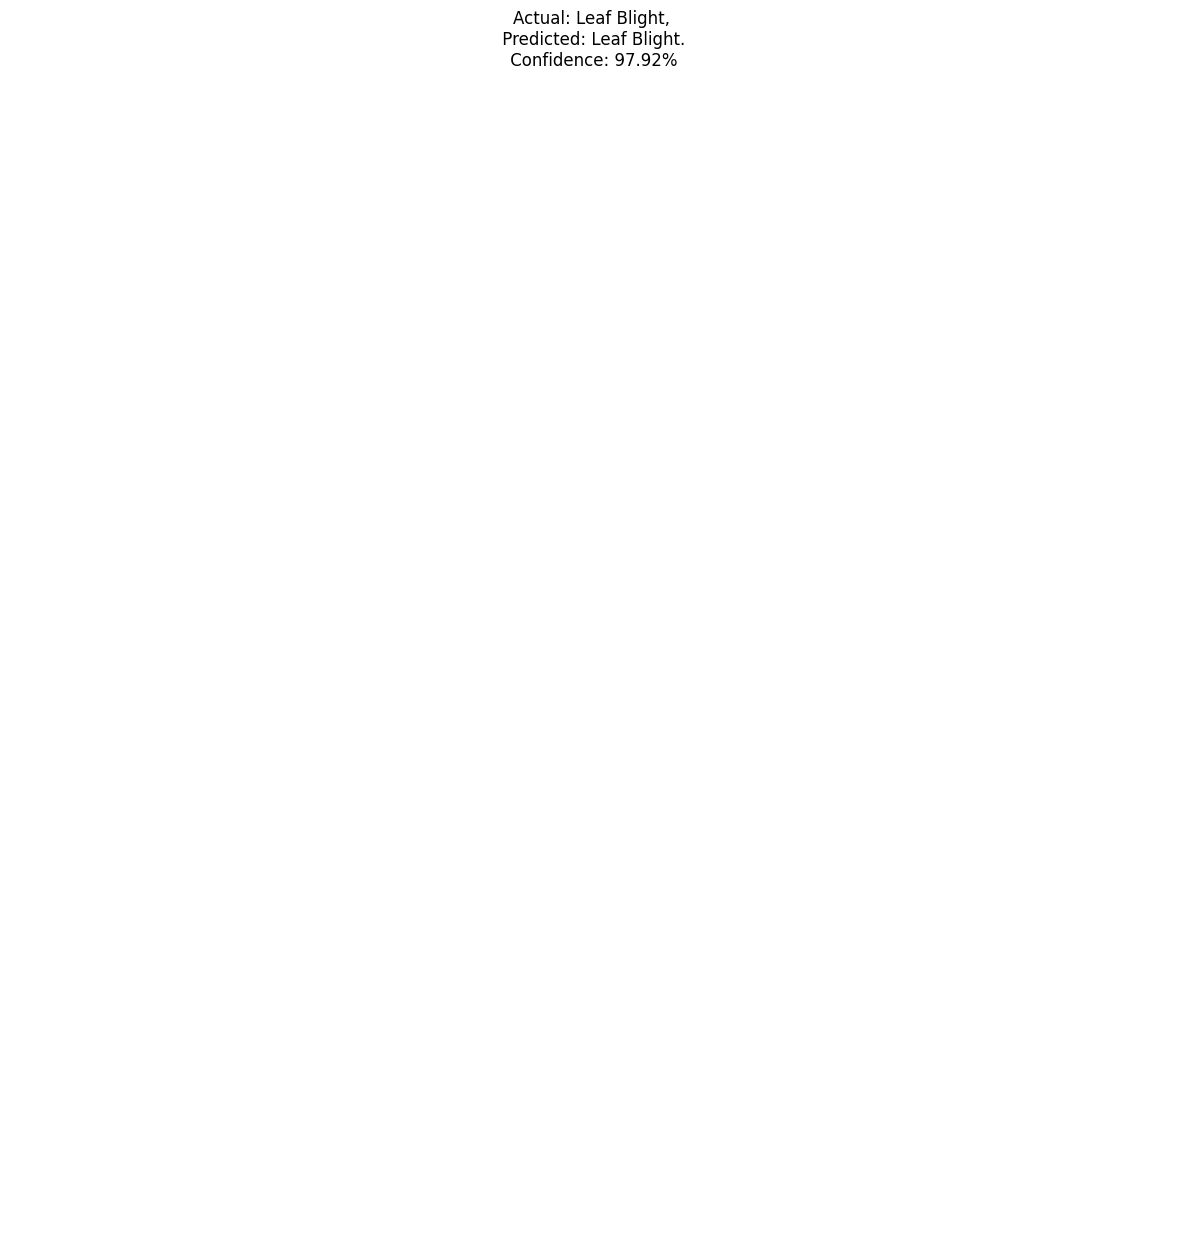

In [47]:
plt.figure(figsize=(15, 15))
predicted_labels = []
actual_labels = []
for images, labels in test_ds:
    for i in range(20):
        # ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]
                                  ] 
        predicted_labels.append(predicted_class)
        actual_labels.append(actual_class)
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [48]:

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

In [49]:
cm=confusion_matrix(y_true=actual_labels, y_pred=predicted_labels)

(<Figure size 800x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

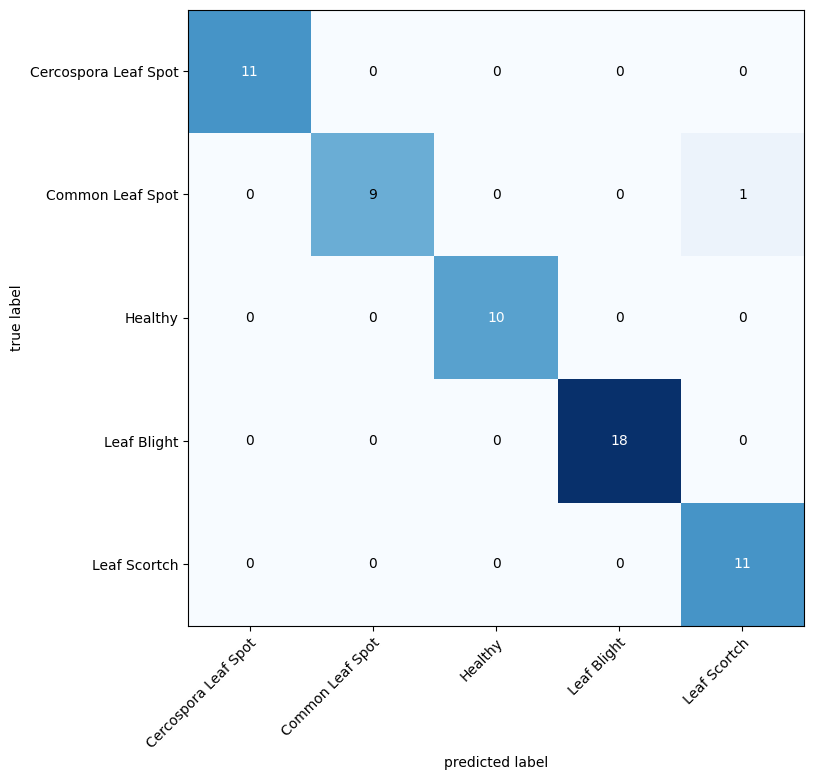

In [50]:
plot_confusion_matrix(conf_mat=cm, figsize=(8,8),class_names=class_names)

In [51]:
print(classification_report(actual_labels,predicted_labels))

                      precision    recall  f1-score   support

Cercospora Leaf Spot       1.00      1.00      1.00        11
    Common Leaf Spot       1.00      0.90      0.95        10
             Healthy       1.00      1.00      1.00        10
         Leaf Blight       1.00      1.00      1.00        18
        Leaf Scortch       0.92      1.00      0.96        11

            accuracy                           0.98        60
           macro avg       0.98      0.98      0.98        60
        weighted avg       0.98      0.98      0.98        60



In [33]:

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets


In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\isaia\AppData\Local\Temp\tmpsmer9qe1\assets


INFO:tensorflow:Assets written to: C:\Users\isaia\AppData\Local\Temp\tmpsmer9qe1\assets
